In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import numpy as np

# Load data
pop_df = pd.read_excel("Population 2014-2024.xlsx", sheet_name="Sheet1")
mh_df = pd.read_excel("table 4 Mental health-related emergency department presentations 2014–15 to 2023–24.xlsx", sheet_name="Sheet1")

# Clean data
mh_df['Age group'] = mh_df['Age group'].str.replace(' years', '').str.replace('85 and over', '85-100')
pop_df['Age'] = pop_df['Age'].str.replace('85 and over', '85-100')
mh_df = mh_df[mh_df['Measure'] == 'Number']
mh_df = mh_df[mh_df['Demographic characteristic'].isin(['Male', 'Female'])]

years = list(range(2014, 2025))
mh_years = [f"{y}–{str(y+1)[-2:]}" for y in range(2014, 2024)]

merged_rows = []
for _, row in mh_df.iterrows():
    sex = row['Demographic characteristic']
    age = row['Age group']
    mh_values = row[mh_years].values

    pop_row = pop_df[(pop_df['Sex'] == sex) & (pop_df['Age'] == age)]
    if not pop_row.empty:
        pop_values = pop_row[years].values[0]
        rate_per_10k = (mh_values / pop_values[:len(mh_values)]) * 10000
        merged_rows.append({
            'Sex': sex,
            'Age': age,
            **{str(2014 + i): rate_per_10k[i] for i in range(len(rate_per_10k))}
        })

merged_df = pd.DataFrame(merged_rows)
melted_df = merged_df.melt(id_vars=['Sex', 'Age'], var_name='Year', value_name='Rate_per_10k')
melted_df['Year'] = melted_df['Year'].astype(int)


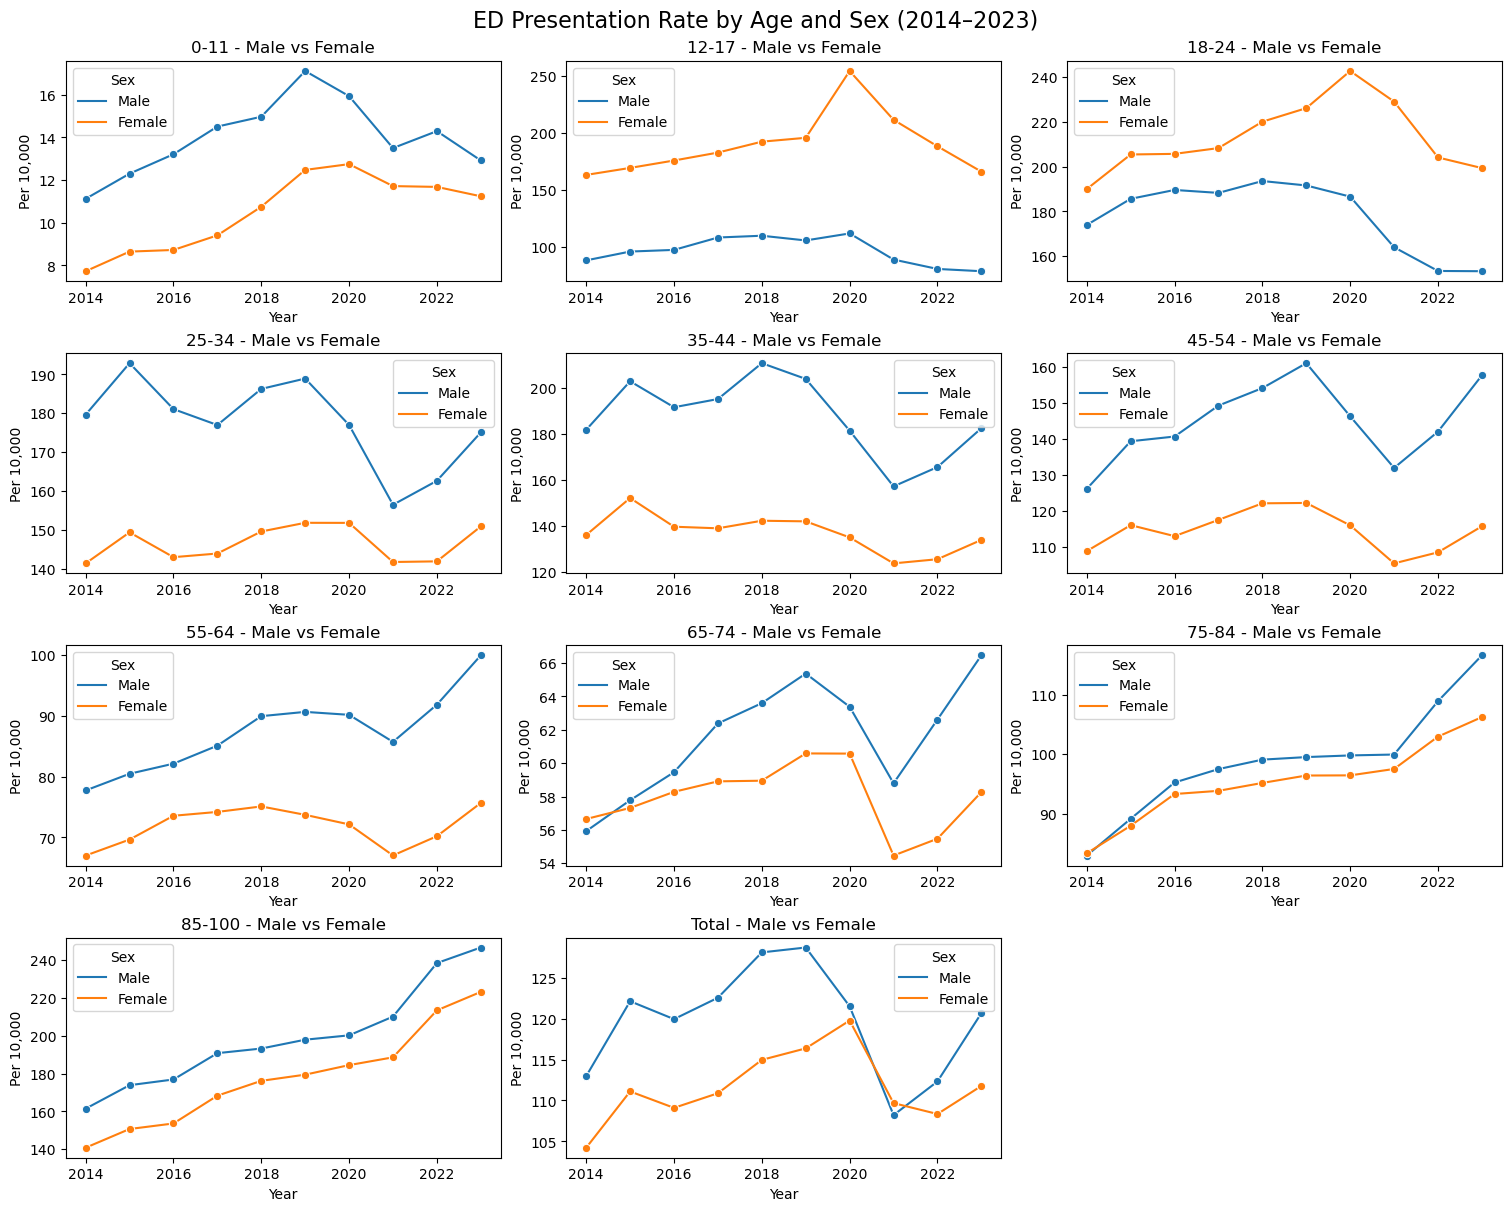

In [8]:

# Plot line charts per age group (male vs female)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

age_groups = sorted(melted_df['Age'].unique())
n = len(age_groups)
cols = 3
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 3), constrained_layout=True)
axes = axes.flatten()

for i, age_group in enumerate(age_groups):
    ax = axes[i]
    sub_df = melted_df[melted_df['Age'] == age_group]
    sns.lineplot(data=sub_df, x='Year', y='Rate_per_10k', hue='Sex', marker='o', ax=ax)
    ax.set_title(f'{age_group} - Male vs Female')
    ax.set_ylabel('Per 10,000')
    ax.set_xlabel('Year')
    ax.legend(title='Sex')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('ED Presentation Rate by Age and Sex (2014–2023)', fontsize=16)
plt.show()


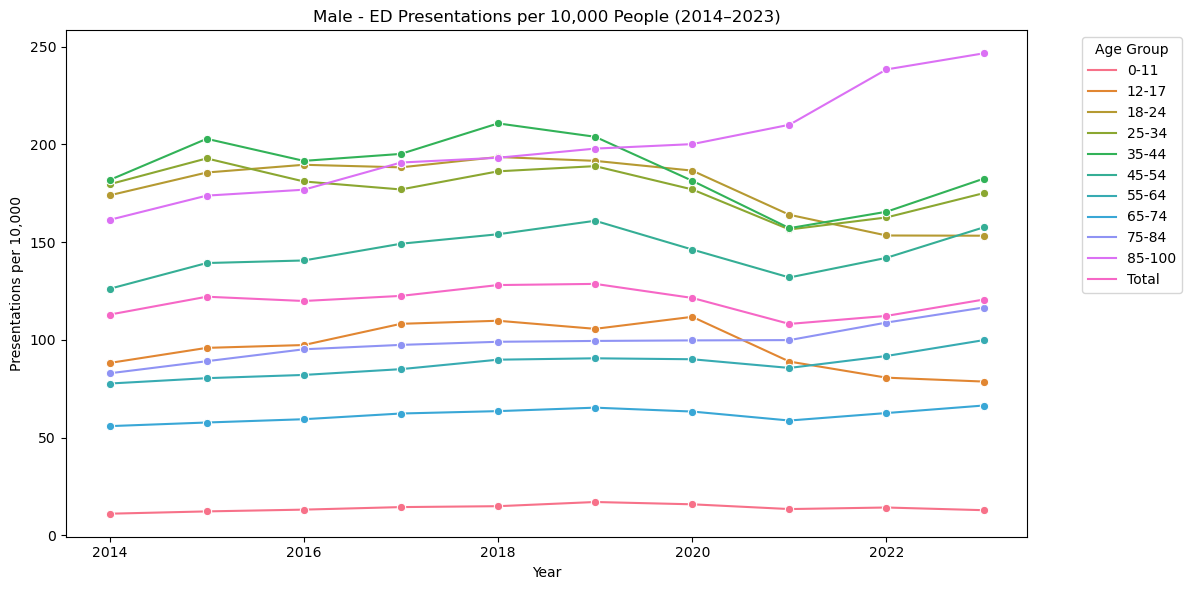

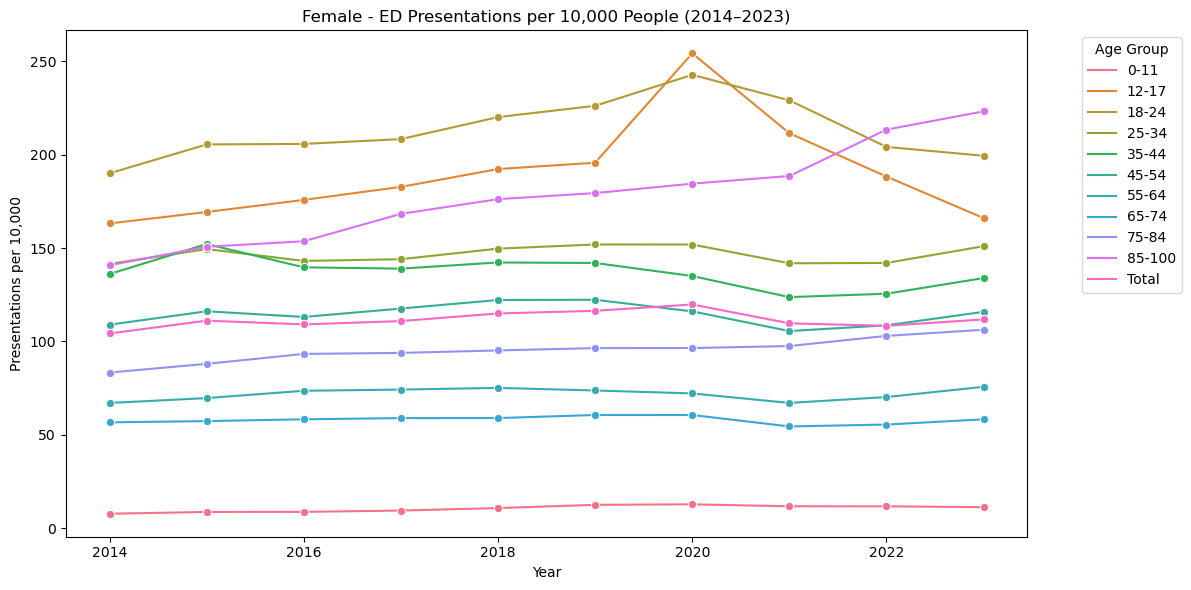

In [9]:

# Plot line charts per gender
for gender in melted_df['Sex'].unique():
    plt.figure(figsize=(12, 6))
    sub_df = melted_df[melted_df['Sex'] == gender]
    sns.lineplot(data=sub_df, x='Year', y='Rate_per_10k', hue='Age', marker='o')
    plt.title(f'{gender} - ED Presentations per 10,000 People (2014–2023)')
    plt.ylabel('Presentations per 10,000')
    plt.xlabel('Year')
    plt.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


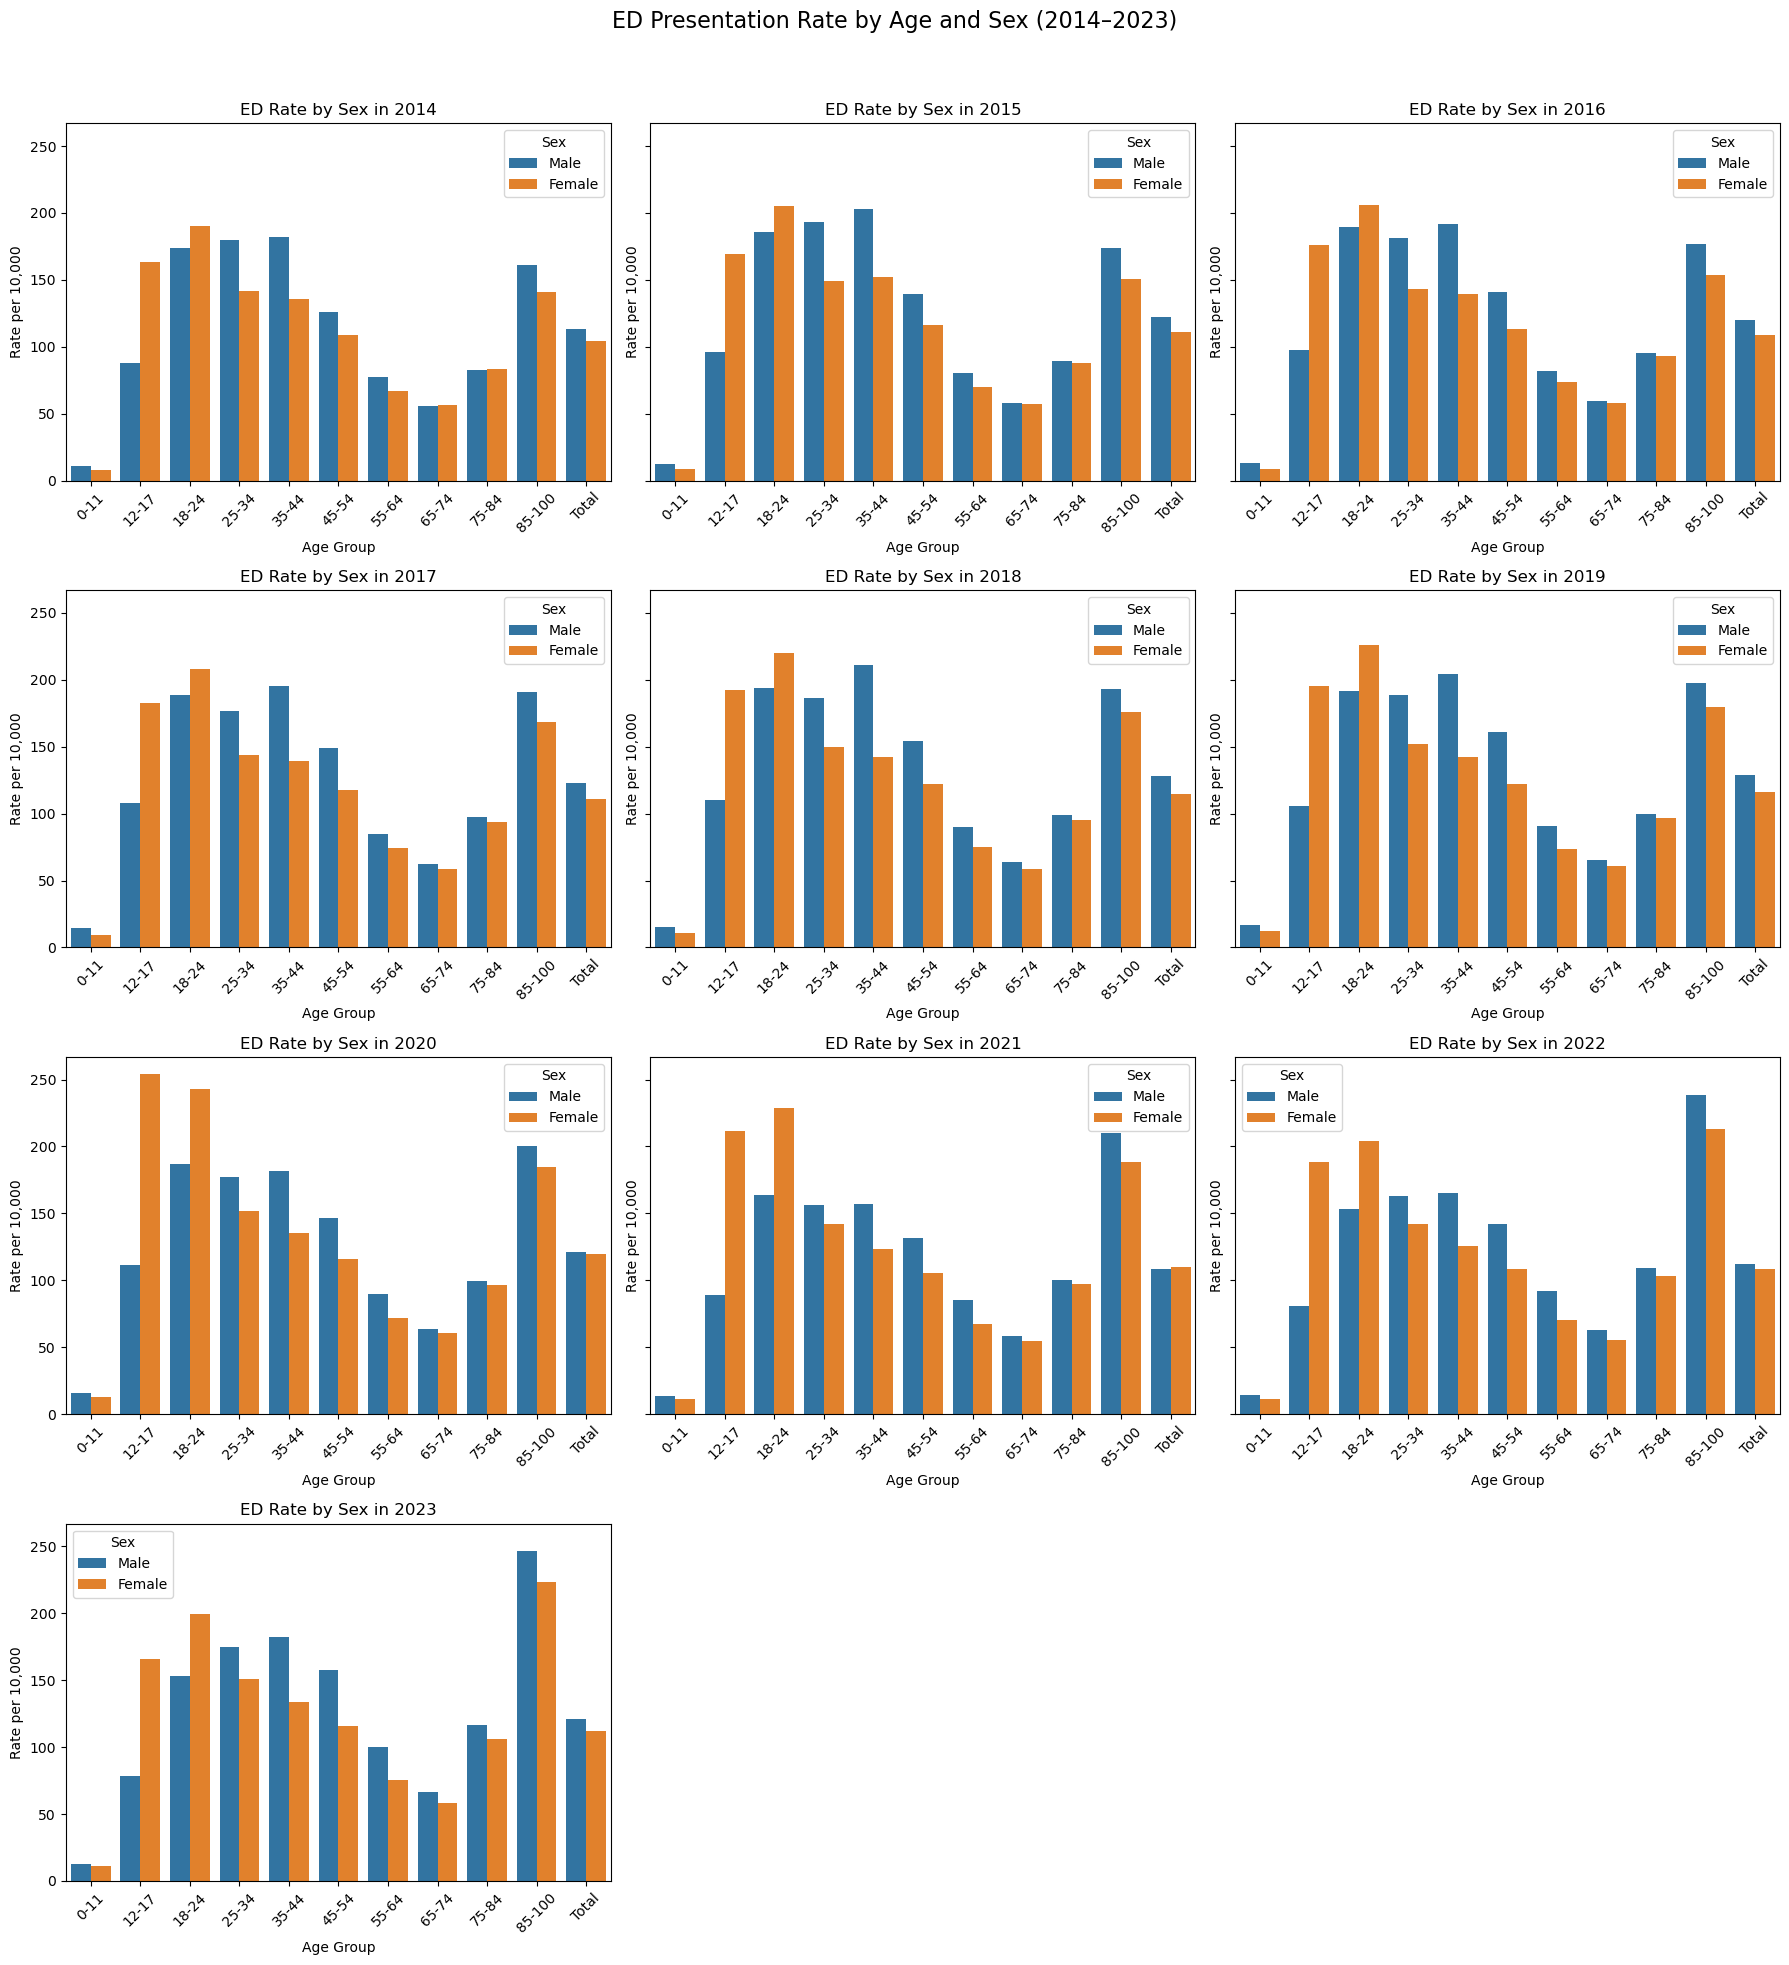

In [13]:

unique_years = sorted(melted_df['Year'].unique())

cols = 3
rows = int(np.ceil(len(unique_years) / cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5), sharey=True)
axes = axes.flatten()

for idx, year in enumerate(unique_years):
    ax = axes[idx]
    bar_df = melted_df[melted_df['Year'] == year]
    sns.barplot(data=bar_df, x='Age', y='Rate_per_10k', hue='Sex', ax=ax)
    ax.set_title(f'ED Rate by Sex in {year}')
    ax.set_xlabel('Age Group')
    ax.set_ylabel('Rate per 10,000')
    ax.tick_params(axis='x', rotation=45)
    ax.legend(title='Sex')

for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('ED Presentation Rate by Age and Sex (2014–2023)', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

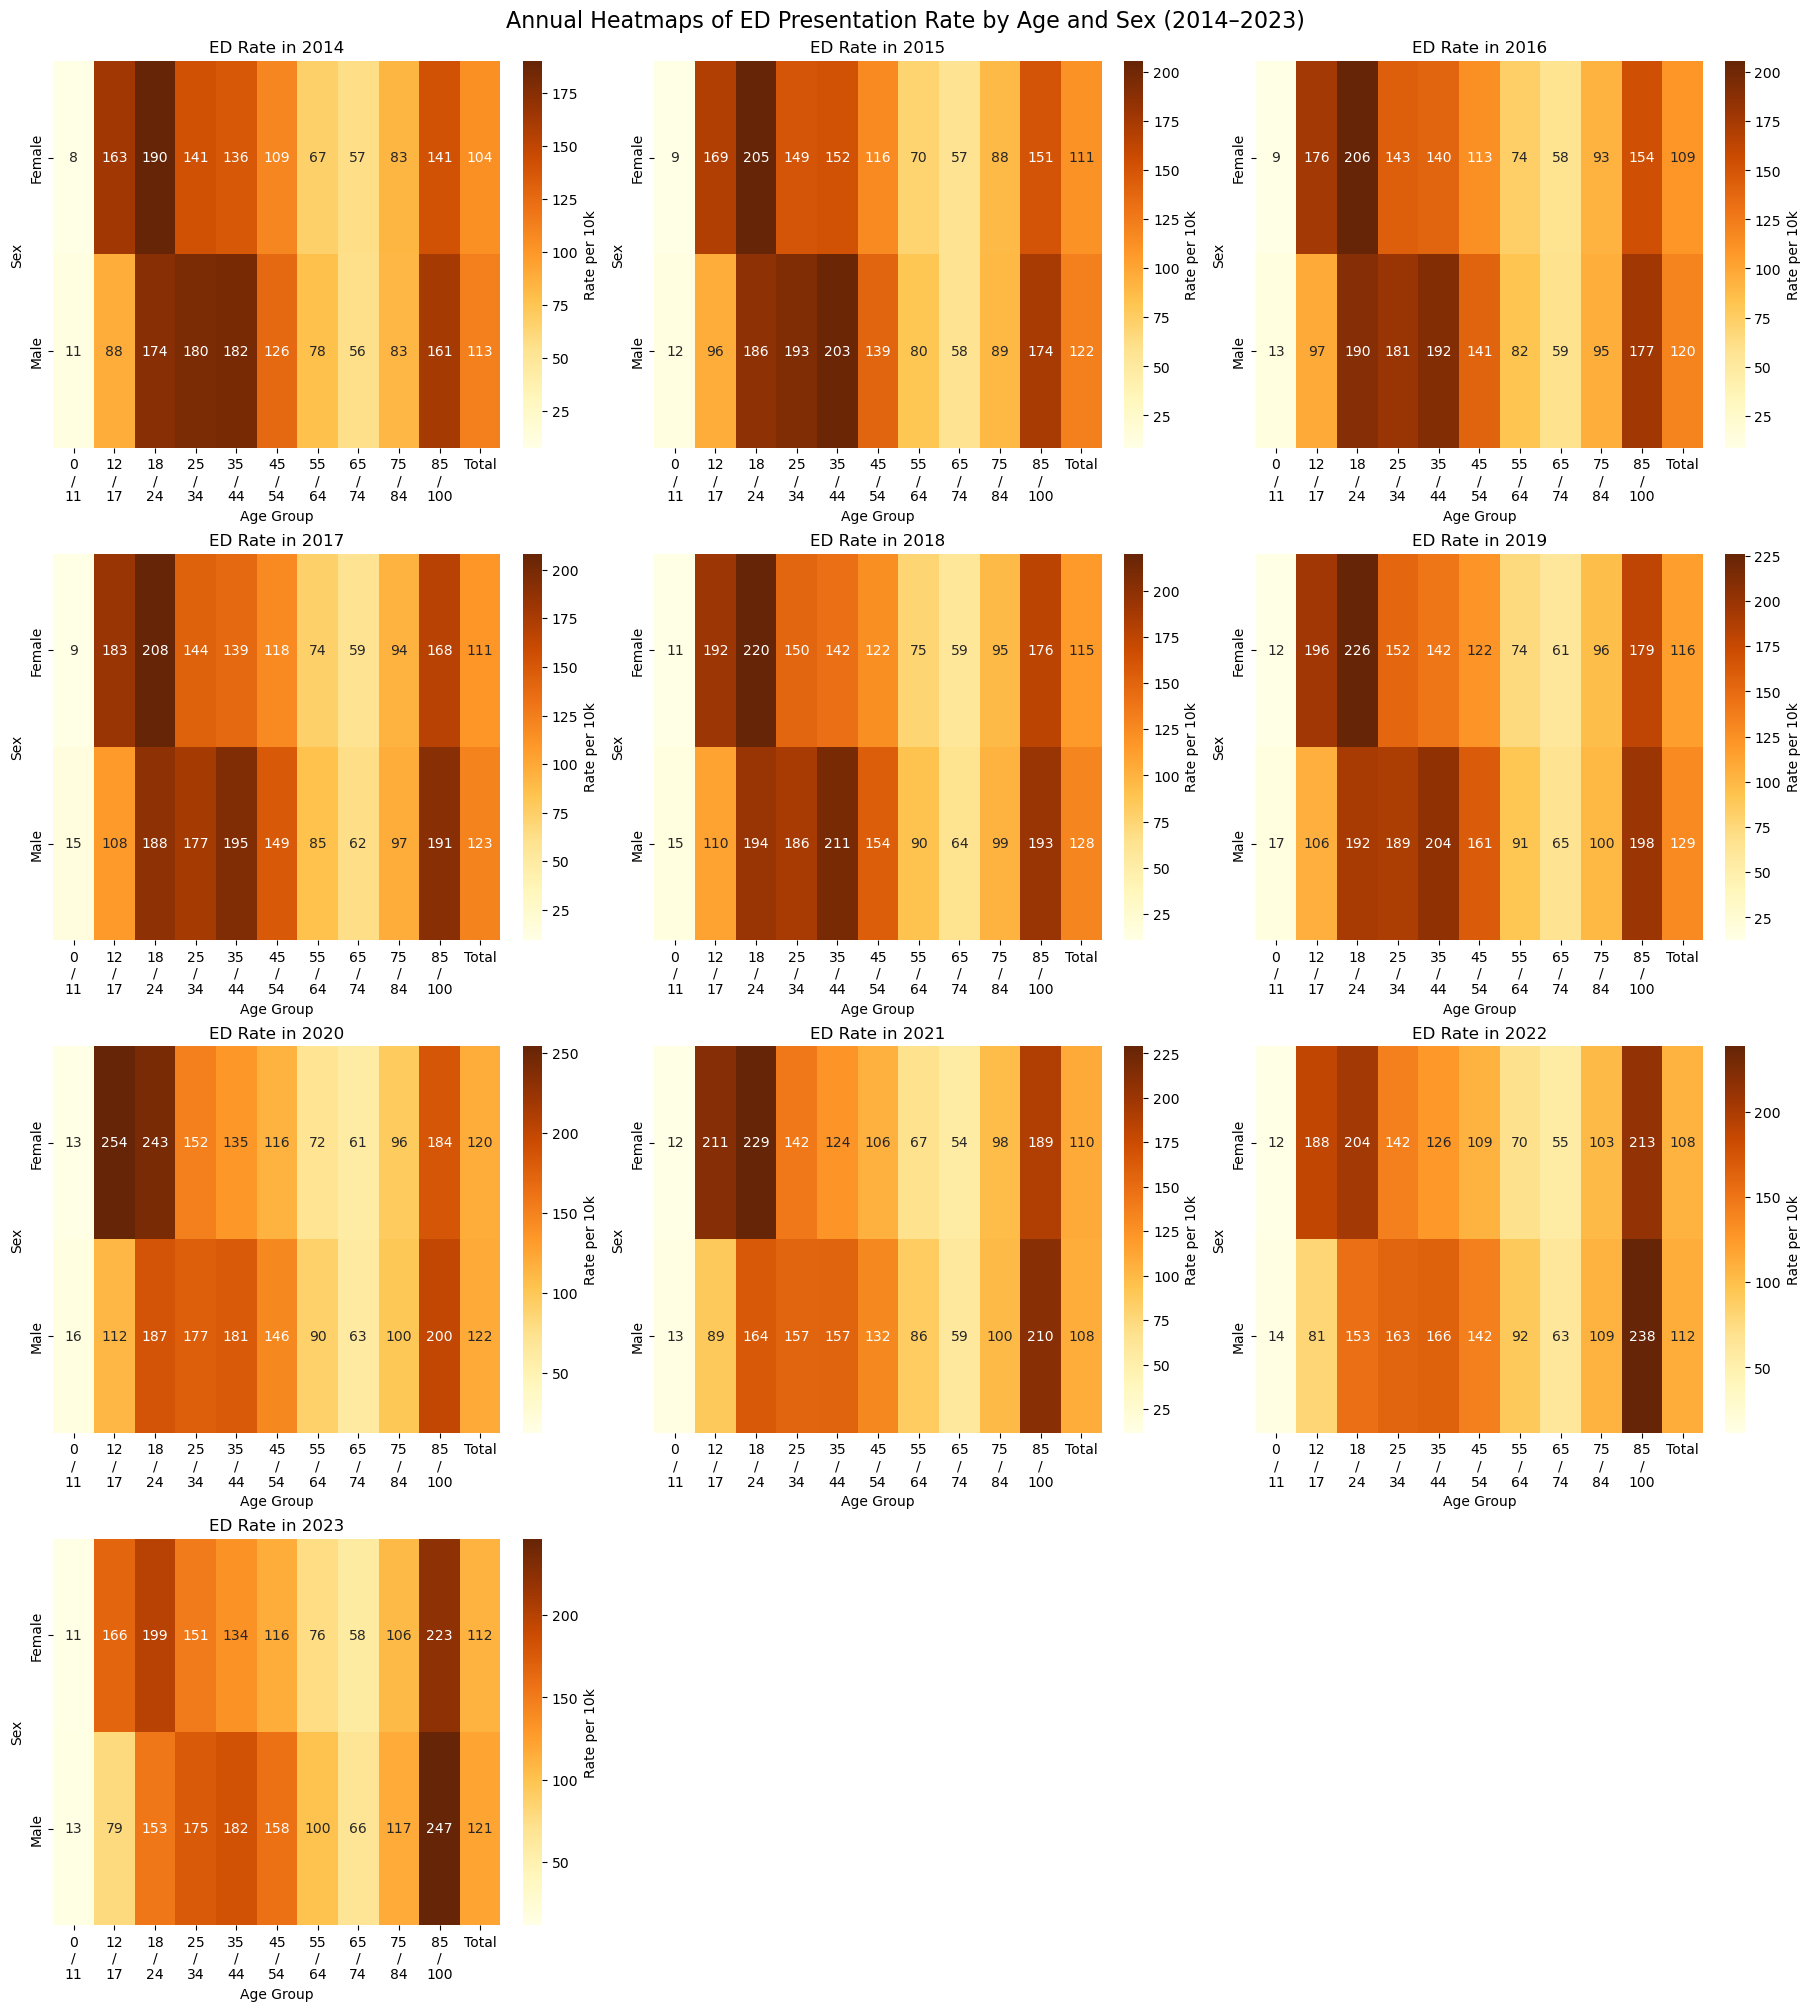

In [11]:

# Annual heatmaps of ED rates by Age and Sex
unique_years = sorted(melted_df['Year'].unique())
cols = 3
rows = int(np.ceil(len(unique_years) / cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5), constrained_layout=True)
axes = axes.flatten()

for idx, year in enumerate(unique_years):
    ax = axes[idx]
    year_df = melted_df[melted_df['Year'] == year]
    pivot = year_df.pivot(index='Sex', columns='Age', values='Rate_per_10k')

    pivot.columns = [label.replace('-', '\n/\n') for label in pivot.columns]

    sns.heatmap(pivot, cmap='YlOrBr', cbar_kws={'label': 'Rate per 10k'}, ax=ax, annot=True, fmt=".0f")
    ax.set_title(f'ED Rate in {year}')
    ax.set_xlabel('Age Group')
    ax.set_ylabel('Sex')
    
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Annual Heatmaps of ED Presentation Rate by Age and Sex (2014–2023)', fontsize=16)
plt.show()



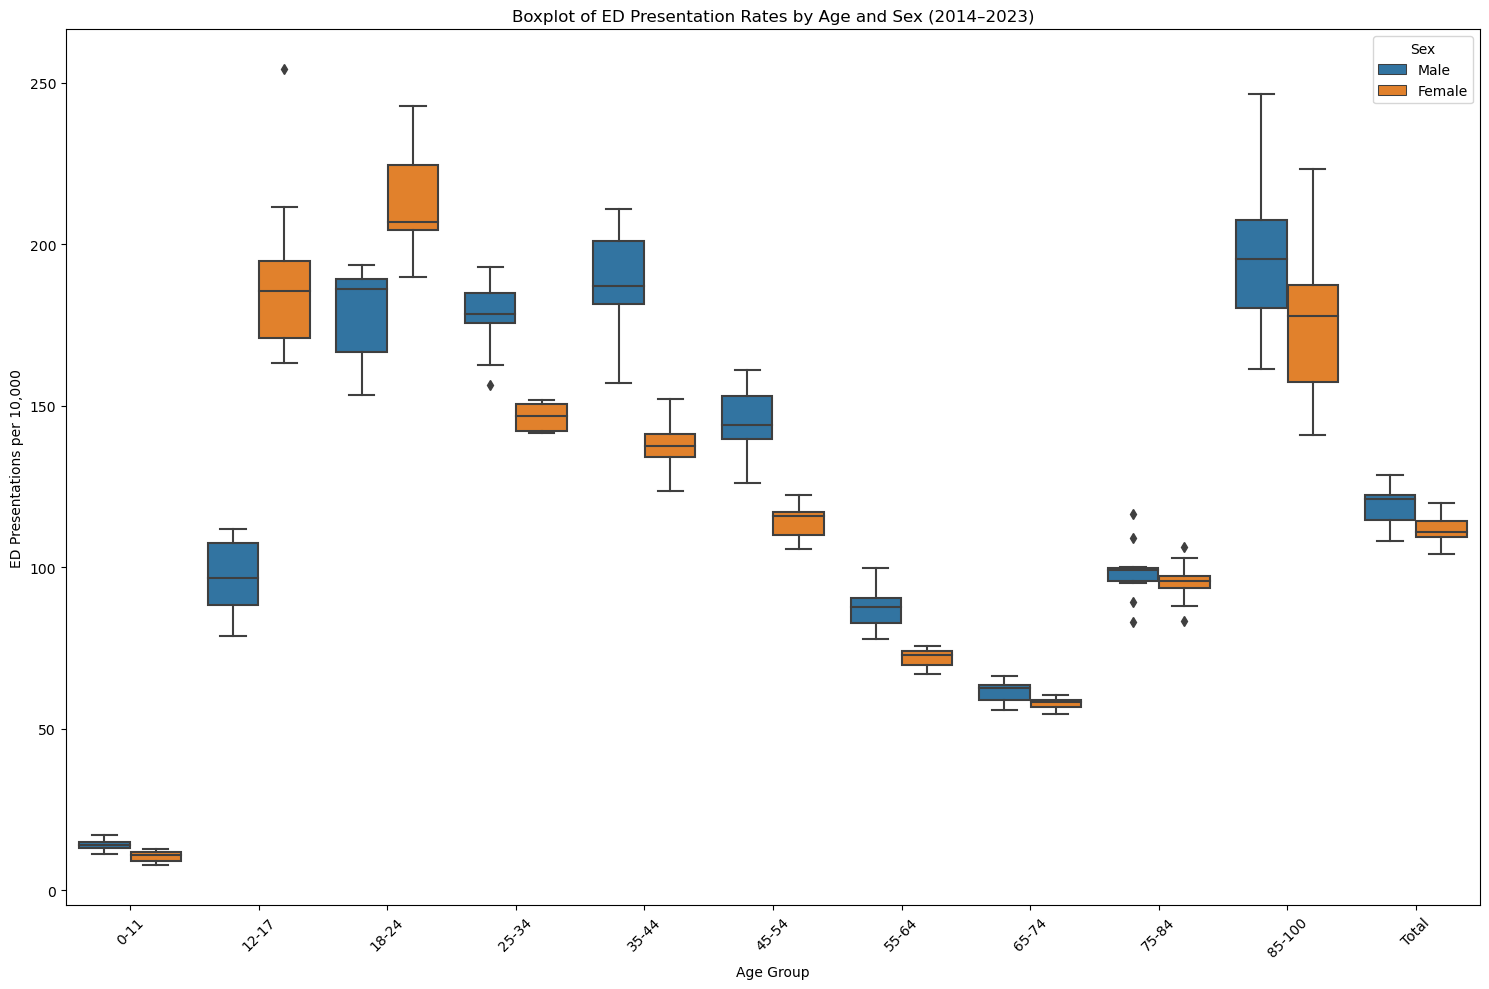

In [29]:

plt.figure(figsize=(15, 10))
sns.boxplot(data=melted_df, x='Age', y='Rate_per_10k', hue='Sex')
plt.title('Boxplot of ED Presentation Rates by Age and Sex (2014–2023)')
plt.xticks(rotation=45)
plt.ylabel('ED Presentations per 10,000')
plt.xlabel('Age Group')
plt.tight_layout()
plt.show()

E:\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


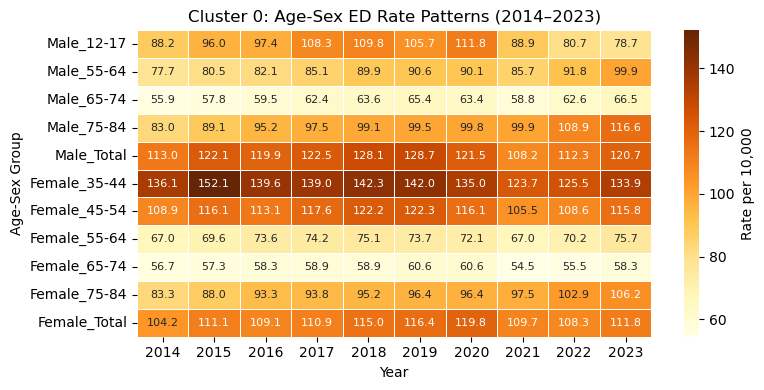

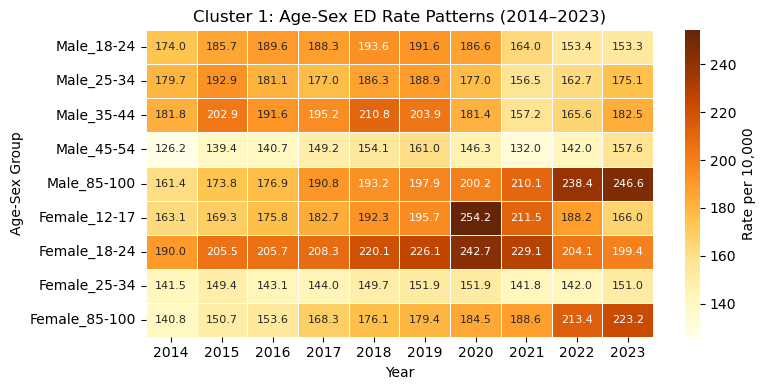

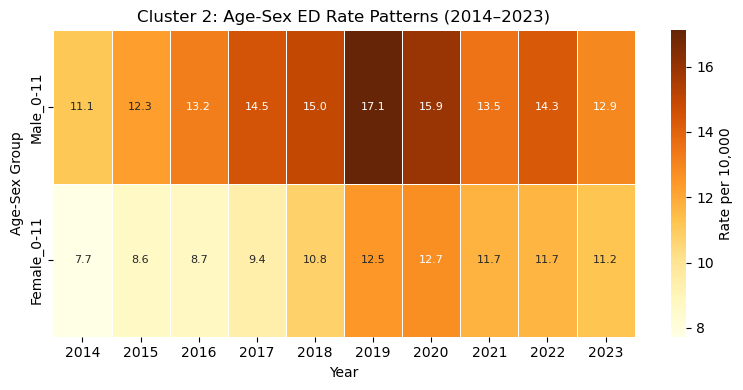

In [30]:

# KMeans clustering and cluster heatmap
cluster_data = merged_df.copy()
cluster_data['Group'] = cluster_data['Sex'] + "_" + cluster_data['Age']
cluster_data = cluster_data.set_index('Group')
cluster_data = cluster_data[[str(y) for y in range(2014, 2024)]]

kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
cluster_data['Cluster'] = kmeans.fit_predict(cluster_data)

# Plot heatmap for each cluster
for cluster_id in sorted(cluster_data['Cluster'].unique()):
    subset = cluster_data[cluster_data['Cluster'] == cluster_id].drop(columns='Cluster')
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.heatmap(subset, cmap='YlOrBr', annot=True, fmt=".1f", linewidths=0.5, ax=ax,
                annot_kws={'size': 8}, cbar_kws={'label': 'Rate per 10,000'})
    ax.set_title(f'Cluster {cluster_id}: Age-Sex ED Rate Patterns (2014–2023)')
    ax.set_xlabel('Year')
    ax.set_ylabel('Age-Sex Group')
    fig.tight_layout()
    plt.show()


Top 5 fastest increasing groups:
      Sex     Age     Slope
0    Male  85-100  8.591380
1  Female  85-100  8.526144
2  Female   12-17  3.363309
3    Male   75-84  2.861065
4  Female   75-84  2.066705


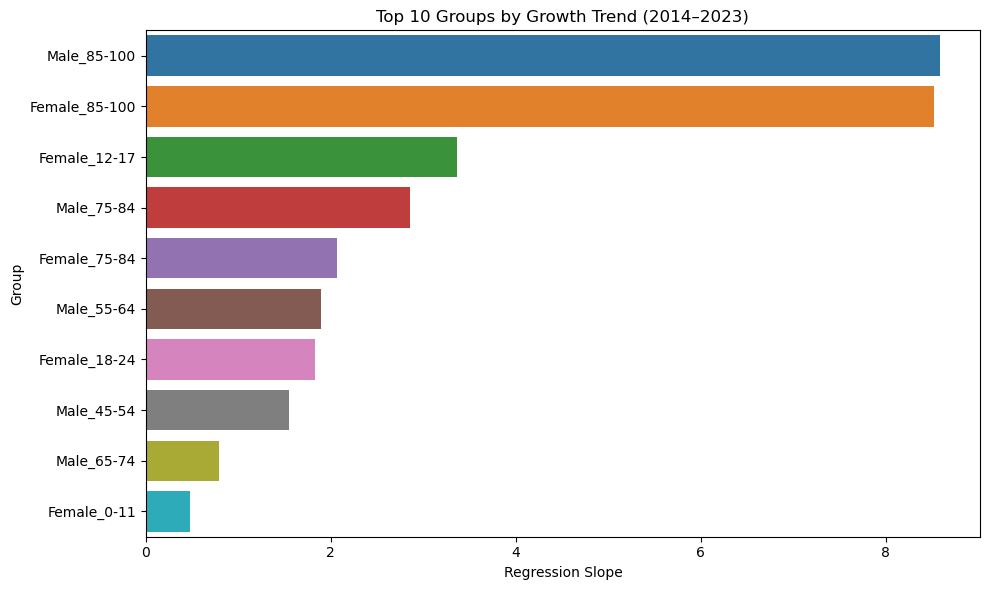

In [22]:
from sklearn.linear_model import LinearRegression

# Prepare to collect slopes
slopes = []

# Group by each Sex + Age
grouped = melted_df[melted_df['Age'] != 'Total'].groupby(['Sex', 'Age'])

for (sex, age), group in grouped:
    X = group['Year'].values.reshape(-1, 1)
    y = group['Rate_per_10k'].values
    model = LinearRegression().fit(X, y)
    slope = model.coef_[0]
    slopes.append({'Sex': sex, 'Age': age, 'Slope': slope})

# Convert to DataFrame and sort
slope_df = pd.DataFrame(slopes)
slope_df_sorted = slope_df.sort_values(by='Slope', ascending=False)
slope_df_sorted.reset_index(drop=True, inplace=True)

# Display top increasing trends
print("Top 5 fastest increasing groups:")
print(slope_df_sorted.head(5))

# Optional: barplot
plt.figure(figsize=(10, 6))
top_slopes = slope_df_sorted.head(10)
sns.barplot(data=top_slopes, x='Slope', y=top_slopes['Sex'] + "_" + top_slopes['Age'])
plt.title("Top 10 Groups by Growth Trend (2014–2023)")
plt.xlabel("Regression Slope")
plt.ylabel("Group")
plt.tight_layout()
plt.show()
